# CS 4824 Project - Ethan Mauger, Fall 2024

This Juypter Notebook runs all of the code associated with my CS 4824 project focused on predicting strokes based on patient health data. This notebook was run by opening Jupyter Notebooks version 6.5.4 on the Anaconda Navigator version 2.6.3. Ensure that the notebook and Kaggle data (healthcare-dataset-stroke-data.csv) are in the same directory.

## 1. Initial Setup

Load data from healthcare-dataset-stroke-data.csv into a pandas dataframe.

In [1]:
import pandas as pd

#Load in the data from the csv file in the same directory as this notebook
raw_data = pd.read_csv("healthcare-dataset-stroke-data.csv")

## 2. Data Preprocessing

Preprocess data so that when it is provided to the models, it will be well formatted.

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#Drop the id column. This data will not be helpful in predicting the probability of a stroke in patients.
data = raw_data.copy()
data = data.drop('id', axis=1)

#Use Label encoding for binary columns such as ever_married and Residence_type, where the number order matters (Yes/No).
label_encoder = LabelEncoder()
for column in ['ever_married', 'Residence_type']:
    data[column] = label_encoder.fit_transform(data[column])

#Use One-Hot encoding for columns in which the order doesn't matter, such as gender, work_type, and smoking_status.
#sparse_output=False to keep data in a numpy array format.
one_hot_encoder = OneHotEncoder(sparse_output=False)
for column in ['gender', 'work_type', 'smoking_status']:
    encoded_data = one_hot_encoder.fit_transform(data[[column]])
    encoded_columns = one_hot_encoder.get_feature_names_out([column])
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)
    data = data.drop(column, axis=1).join(encoded_df)

## 3. Imputation Methods

Imputate the bmi column using three different methods that will be paired with sampling strategies below. The three pairings will be baseline processing (Mean Imputation), research processing (Multiple Imputation by Chained Equations (MICE)), and exploratory processing (K Nearest Neighbors Imputation (KNN)).

In [3]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

#Take initial preprocessing and copy it for the other processing pairings.
baseline_data = data.copy()
research_data = data.copy()
exploratory_data = data.copy()

#Set up Z-score normalization for each pairing. Normalization will cover all of the data except for the stroke column.
scaler = StandardScaler()
columns_to_normalize = [col for col in data.columns if col != 'stroke']

#Baseline: Imputate the bmi column with Mean Imputation to replace missing data.
baseline_data['bmi'] = baseline_data['bmi'].fillna(baseline_data['bmi'].mean())

baseline_data[columns_to_normalize] = scaler.fit_transform(baseline_data[columns_to_normalize])

#Research: Imputate the bmi column with MICE Imputation.
research_imputer = IterativeImputer(random_state=23)
research_data['bmi'] = research_imputer.fit_transform(research_data[['bmi']])

research_data[columns_to_normalize] = scaler.fit_transform(research_data[columns_to_normalize])

#Exploratory: Imputate the bmi column with KNN Imputation.
exploratory_imputer = KNNImputer()
exploratory_data['bmi'] = exploratory_imputer.fit_transform(exploratory_data[['bmi']])

exploratory_data[columns_to_normalize] = scaler.fit_transform(exploratory_data[columns_to_normalize])

### 3.1. Exploring Imputation Methods

By looking at the statistics of the imputated bmi column, it is clear that within the data, the imputation methods don't actually differ in imputated values. This could be caused by a lack of missing data, with only 0.32% of data being missing, or due to the fact that all of these methods tend to converge towards the mean, ensuring similar imputation. Regardless, it is important to imputate to remove missing data from the dataset.

In [4]:
#Calculate the percentage of missing values in the initial dataframe.
missing = (raw_data.isnull().sum().sum() / raw_data.size) * 100

print("Percentage of Missing Values in DataFrame: ", missing, "\n")

#Creates a DataFrame to show differences in column statistics.
baseline_stats = baseline_data['bmi'].describe()
research_stats = research_data['bmi'].describe()
exploratory_stats = exploratory_data['bmi'].describe()

imputated_stats = pd.DataFrame({
    'Baseline': baseline_stats,
    'Research': research_stats,
    'Exploratory': exploratory_stats
})

print("BMI Column Statistics After Different Imputation Methods:")
imputated_stats

Percentage of Missing Values in DataFrame:  0.32778864970645794 

BMI Column Statistics After Different Imputation Methods:


,Baseline,Research,Exploratory
count,5.110000e+03,5.110000e+03,5.110000e+03
mean,2.224791e-17,2.224791e-17,2.224791e-17
std,1.000098e+00,1.000098e+00,1.000098e+00
min,-2.415564e+00,-2.415564e+00,-2.415564e+00
25%,-6.616944e-01,-6.616944e-01,-6.616944e-01
50%,-6.407951e-02,-6.407951e-02,-6.407951e-02
75%,5.075521e-01,5.075521e-01,5.075521e-01
max,8.926127e+00,8.926127e+00,8.926127e+00


## 4. Oversampling Methods

Sample the data to balance the number of rows that are stroke positive with the number of rows that are stroke negative. The methods will be paired with the imputation methods above to form the three groups created. The baseline processing pairing will use Random Oversampling, the research processing pairing will use Synthetic Minority Oversampling (SMOTE), and the exploratory processing pairing will use Adaptive Synthetic Sampling (ADASYN).

In [5]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

#Baseline: Oversample using Random Oversampling. Make sure to separate features initially.
x_baseline = baseline_data.drop('stroke', axis=1)
y_baseline = baseline_data['stroke']

baseline_sampler = RandomOverSampler(random_state=23)
x_baseline_resampled, y_baseline_resampled = baseline_sampler.fit_resample(x_baseline, y_baseline)

#Research: Oversample using SMOTE. Make sure to separate features initially.
x_research = research_data.drop('stroke', axis=1)
y_research = research_data['stroke']

research_sampler = SMOTE(random_state=23)
x_research_resampled, y_research_resampled = research_sampler.fit_resample(x_research, y_research)

#Exploratory: Oversample using ADASYN. Make sure to separate features initially.
x_exploratory = exploratory_data.drop('stroke', axis=1)
y_exploratory = exploratory_data['stroke']

exploratory_sampler = ADASYN(random_state=23)
x_exploratory_resampled, y_exploratory_resampled = exploratory_sampler.fit_resample(x_exploratory, y_exploratory)

### 4.1. Exploring Oversampling Techniques

Oversampling is required because of how little positives are represented within the data. As shown below, the raw data only has about 5% of stroke cases, which will make it more difficult for the models to train for both cases. The three different oversampling techniques aim to make it closer, with Random Oversampling repeating rows already found in the dataset and SMOTE/ADASYN generating synthetic data.

In [6]:
#Class distribution before oversampling
raw_distribution = raw_data['stroke'].value_counts(normalize=True) * 100
print("Before Oversampling Stroke Percentage:", raw_distribution.get(1, 0))
print("Before Oversampling Non-Stroke Percentage:", raw_distribution.get(0, 0), "\n")

#Class distribution with Random Oversampling
baseline_distribution = y_baseline_resampled.value_counts(normalize=True) * 100
print("Random Oversampling Stroke Percentage:", baseline_distribution.get(1, 0))
print("Random Oversampling Non-Stroke Percentage:", baseline_distribution.get(0, 0), "\n")

#Class distribution with SMOTE
research_distribution = y_research_resampled.value_counts(normalize=True) * 100
print("SMOTE Stroke Percentage:", research_distribution.get(1, 0))
print("SMOTE Non-Stroke Percentage:", research_distribution.get(0, 0), "\n")

#Class distribution with ADASYN
exploratory_distribution = y_exploratory_resampled.value_counts(normalize=True) * 100
print("ADASYN Stroke Percentage:", exploratory_distribution.get(1, 0))
print("ADASYN Non-Stroke Percentage:", exploratory_distribution.get(0, 0), "\n")

Before Oversampling Stroke Percentage: 4.87279843444227
Before Oversampling Non-Stroke Percentage: 95.12720156555773 

Random Oversampling Stroke Percentage: 50.0
Random Oversampling Non-Stroke Percentage: 50.0 

SMOTE Stroke Percentage: 50.0
SMOTE Non-Stroke Percentage: 50.0 

ADASYN Stroke Percentage: 50.15892545883318
ADASYN Non-Stroke Percentage: 49.84107454116682 



## 5. Split Data

Now, split the fully preprocessed pairings into training, testing, and validation datasets to be used with the models. A 25% split was chosen based on researched recommendations and wanting there to be enough testing data so that the model wouldn't overfit.

In [7]:
from sklearn.model_selection import train_test_split

#Baseline
x_train_baseline, x_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    x_baseline_resampled, y_baseline_resampled, test_size=0.25, random_state=23)

#Research
x_train_research, x_test_research, y_train_research, y_test_research = train_test_split(
    x_research_resampled, y_research_resampled, test_size=0.25, random_state=23)

#Exploratory
x_train_exploratory, x_test_exploratory, y_train_exploratory, y_test_exploratory = train_test_split(
    x_exploratory_resampled, y_exploratory_resampled, test_size=0.25, random_state=23)

## 6. Initial Model Creation

The data has now been preprocessed through the baseline, research, and exploratory pairings and is fully cleaned. The next steps in this project include creating, training, and tuning the machine learning models to be compared. The four models that will be compared are Stocastic Gradient Descent (SGD) with logistic regression, Multilayer Perceptron (MLP), Gaussian Naive Bayes (GNB), and K Nearest Neighbors (KNN). The initial models with default parameters before feature engineering are below. The paper explains how each model works and why the model was chosen in detail.

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#Initial training and testing for the SGD Classifier with a logarithmic loss function across all three pairings.
sgd = SGDClassifier(loss='log_loss', random_state=23)

sgd.fit(x_train_baseline, y_train_baseline)
sgd_train_pred_baseline = sgd.predict(x_train_baseline)
sgd_y_pred_baseline = sgd.predict(x_test_baseline)

sgd.fit(x_train_research, y_train_research)
sgd_train_pred_research = sgd.predict(x_train_research)
sgd_y_pred_research = sgd.predict(x_test_research)

sgd.fit(x_train_exploratory, y_train_exploratory)
sgd_train_pred_exploratory = sgd.predict(x_train_exploratory)
sgd_y_pred_exploratory = sgd.predict(x_test_exploratory)

#Initial training and testing for the GNB Classifier across all three pairings.
gnb = GaussianNB()

gnb.fit(x_train_baseline, y_train_baseline)
gnb_train_pred_baseline = gnb.predict(x_train_baseline)
gnb_y_pred_baseline = gnb.predict(x_test_baseline)

gnb.fit(x_train_research, y_train_research)
gnb_train_pred_research = gnb.predict(x_train_research)
gnb_y_pred_research = gnb.predict(x_test_research)

gnb.fit(x_train_exploratory, y_train_exploratory)
gnb_train_pred_exploratory = gnb.predict(x_train_exploratory)
gnb_y_pred_exploratory = gnb.predict(x_test_exploratory)

#Initial training and testing for the MLP Classifier across all three pairings.
mlp = MLPClassifier(random_state=23)

mlp.fit(x_train_baseline, y_train_baseline)
mlp_train_pred_baseline = mlp.predict(x_train_baseline)
mlp_y_pred_baseline = mlp.predict(x_test_baseline)

mlp.fit(x_train_research, y_train_research)
mlp_train_pred_research = mlp.predict(x_train_research)
mlp_y_pred_research = mlp.predict(x_test_research)

mlp.fit(x_train_exploratory, y_train_exploratory)
mlp_train_pred_exploratory = mlp.predict(x_train_exploratory)
mlp_y_pred_exploratory = mlp.predict(x_test_exploratory)

#Initial training and testing for the KNN Classifier across all three pairings.
knn = KNeighborsClassifier()

knn.fit(x_train_baseline, y_train_baseline)
knn_train_pred_baseline = knn.predict(x_train_baseline)
knn_y_pred_baseline = knn.predict(x_test_baseline)

knn.fit(x_train_research, y_train_research)
knn_train_pred_research = knn.predict(x_train_research)
knn_y_pred_research = knn.predict(x_test_research)

knn.fit(x_train_exploratory, y_train_exploratory)
knn_train_pred_exploratory = knn.predict(x_train_exploratory)
knn_y_pred_exploratory = knn.predict(x_test_exploratory)

C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 6.1. Evaluating Initial Models

After the initial models have been trained and tested, it is time to see a breakdown of the different models. The train_accuracy, test_accuracy, precision, recall, f1, and roc_auc for each initial model with each preprocessing pairing are calculated and stored in the cell below.

Text(0.5, 1.0, 'Test Accuracy by Initial Model and Preprocessing Pairing')

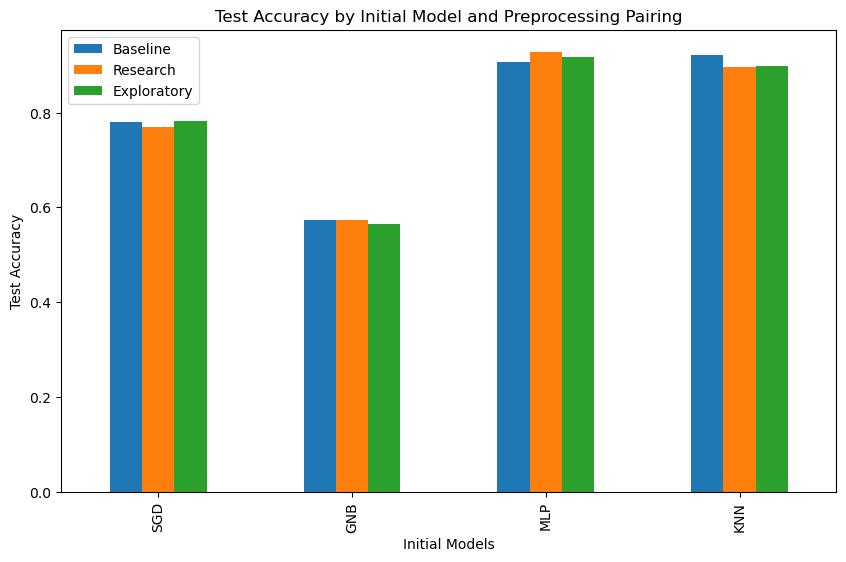

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = ['SGD', 'GNB', 'MLP', 'KNN']
pairings = ['Baseline', 'Research', 'Exploratory']

#All model data stored in these dictionaries. Use these to calculate scores.
train_actual = {'Baseline': y_train_baseline, 'Research': y_train_research, 'Exploratory': y_train_exploratory}
train_predictions = {
    'SGD': {'Baseline': sgd_train_pred_baseline, 'Research': sgd_train_pred_research, 'Exploratory': sgd_train_pred_exploratory},
    'GNB': {'Baseline': gnb_train_pred_baseline, 'Research': gnb_train_pred_research, 'Exploratory': gnb_train_pred_exploratory},
    'MLP': {'Baseline': mlp_train_pred_baseline, 'Research': mlp_train_pred_research, 'Exploratory': mlp_train_pred_exploratory},
    'KNN': {'Baseline': knn_train_pred_baseline, 'Research': knn_train_pred_research, 'Exploratory': knn_train_pred_exploratory},
}

test_actual = {'Baseline': y_test_baseline, 'Research': y_test_research, 'Exploratory': y_test_exploratory}
test_predictions = {
    'SGD': {'Baseline': sgd_y_pred_baseline, 'Research': sgd_y_pred_research, 'Exploratory': sgd_y_pred_exploratory},
    'GNB': {'Baseline': gnb_y_pred_baseline, 'Research': gnb_y_pred_research, 'Exploratory': gnb_y_pred_exploratory},
    'MLP': {'Baseline': mlp_y_pred_baseline, 'Research': mlp_y_pred_research, 'Exploratory': mlp_y_pred_exploratory},
    'KNN': {'Baseline': knn_y_pred_baseline, 'Research': knn_y_pred_research, 'Exploratory': knn_y_pred_exploratory},
}

#Store all metrics in a mutlileveled dictionary for easy access.
initial_results = {model: {pair: {} for pair in pairings} for model in models}

for model in models:
    for pair in pairings:
        initial_results[model][pair] = {
            'train_accuracy': accuracy_score(train_actual[pair], train_predictions[model][pair]),
            'test_accuracy': accuracy_score(test_actual[pair], test_predictions[model][pair]),
            'precision': precision_score(test_actual[pair], test_predictions[model][pair]),
            'recall': recall_score(test_actual[pair], test_predictions[model][pair]),
            'f1': f1_score(test_actual[pair], test_predictions[model][pair]),
            'roc_auc': roc_auc_score(test_actual[pair], test_predictions[model][pair])
        }
        
#Display a graph with the test accuracies for each model and pairing.

desired_metric = 'test_accuracy' #Change the metric type here.

test_accuracy_df = pd.DataFrame({model: {pair: initial_results[model][pair][desired_metric] for pair in pairings} for model in models}).T
fig, ax = plt.subplots(figsize=(10, 6))
test_accuracy_df.plot(kind='bar', ax=ax)

ax.set_xlabel('Initial Models')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy by Initial Model and Preprocessing Pairing')

## 7. Feature Engineering and Parameter Tuning

After the initial creation of the models, there are some clear indicators for improvement. The GNB Classifier performed significantly worse than the rest of the models, possibly because the data might be much more dependent on each other since it is health data. In addition, the MLP Classifier didn't converge, noting that more iterations might be necessary. This section solves these problems through using GridSearchCV to tune hyperparameters for each model. NOTE: This section takes a while to run. If you would like to speed up the process, comment out most of the mlp_parameters.

In [12]:
from sklearn.model_selection import GridSearchCV

#Parameter tuning and follow up training and testing for the SGD Classifier.
sgd_parameters = {
    'alpha': [0.001, 0.003, 0.005, 0.007],
    'penalty': ['l2', 'l1', 'elasticnet'], 
    'max_iter': [200, 300, 400]              
}

new_sgd = SGDClassifier(loss = 'log_loss', random_state = 23)

sgd_gscv_base = GridSearchCV(estimator = new_sgd, param_grid = sgd_parameters, scoring = 'accuracy', verbose = 1)
sgd_gscv_base.fit(x_train_baseline, y_train_baseline)
new_sgd_train_pred_baseline = sgd_gscv_base.best_estimator_.predict(x_train_baseline)
new_sgd_y_pred_baseline = sgd_gscv_base.best_estimator_.predict(x_test_baseline)

sgd_gscv_research = GridSearchCV(estimator = new_sgd, param_grid = sgd_parameters, scoring = 'accuracy', verbose = 1)
sgd_gscv_research.fit(x_train_research, y_train_research)
new_sgd_train_pred_research = sgd_gscv_research.best_estimator_.predict(x_train_research)
new_sgd_y_pred_research = sgd_gscv_research.best_estimator_.predict(x_test_research)

sgd_gscv_explore = GridSearchCV(estimator = new_sgd, param_grid = sgd_parameters, scoring = 'accuracy', verbose = 1)
sgd_gscv_explore.fit(x_train_exploratory, y_train_exploratory)
new_sgd_train_pred_exploratory = sgd_gscv_explore.best_estimator_.predict(x_train_exploratory)
new_sgd_y_pred_exploratory = sgd_gscv_explore.best_estimator_.predict(x_test_exploratory)

print("\n")
print("SGD best parameters for baseline data:", sgd_gscv_base.best_params_)
print("SGD best parameters for research data:", sgd_gscv_research.best_params_)
print("SGD best parameters for exploratory data:", sgd_gscv_explore.best_params_)
print("\n")

#Parameter tuning and follow up training and testing for the new MND Classifier.
gnb_parameters = {
    'var_smoothing': [1e-4, 1e-2, 1e-3]
}

new_gnb = GaussianNB()

gnb_gscv_base = GridSearchCV(estimator = new_gnb, param_grid = gnb_parameters, scoring = 'accuracy', verbose = 1)
gnb_gscv_base.fit(x_train_baseline, y_train_baseline)
new_gnb_train_pred_baseline = gnb_gscv_base.best_estimator_.predict(x_train_baseline)
new_gnb_y_pred_baseline = gnb_gscv_base.best_estimator_.predict(x_test_baseline)

gnb_gscv_research = GridSearchCV(estimator = new_gnb, param_grid = gnb_parameters, scoring = 'accuracy', verbose = 1)
gnb_gscv_research.fit(x_train_research, y_train_research)
new_gnb_train_pred_research = gnb_gscv_research.best_estimator_.predict(x_train_research)
new_gnb_y_pred_research = gnb_gscv_research.best_estimator_.predict(x_test_research)

gnb_gscv_explore = GridSearchCV(estimator = new_gnb, param_grid = gnb_parameters, scoring = 'accuracy', verbose = 1)
gnb_gscv_explore.fit(x_train_exploratory, y_train_exploratory)
new_gnb_train_pred_exploratory = gnb_gscv_explore.best_estimator_.predict(x_train_exploratory)
new_gnb_y_pred_exploratory = gnb_gscv_explore.best_estimator_.predict(x_test_exploratory)

print("\n")
print("GNB best parameters for baseline data:", gnb_gscv_base.best_params_)
print("GNB best parameters for research data:", gnb_gscv_research.best_params_)
print("GNB best parameters for exploratory data:", gnb_gscv_explore.best_params_)
print("\n")

#Parameter tuning and follow up training and testing for the MLP Classifier.
mlp_parameters = {
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.003, 0.005],
    'max_iter': [500]
}

new_mlp = MLPClassifier(random_state = 23)

mlp_gscv_base = GridSearchCV(estimator = new_mlp, param_grid = mlp_parameters, scoring = 'accuracy', verbose = 1)
mlp_gscv_base.fit(x_train_baseline, y_train_baseline)
new_mlp_train_pred_baseline = mlp_gscv_base.best_estimator_.predict(x_train_baseline)
new_mlp_y_pred_baseline = mlp_gscv_base.best_estimator_.predict(x_test_baseline)

mlp_gscv_research = GridSearchCV(estimator = new_mlp, param_grid = mlp_parameters, scoring = 'accuracy', verbose = 1)
mlp_gscv_research.fit(x_train_research, y_train_research)
new_mlp_train_pred_research = mlp_gscv_research.best_estimator_.predict(x_train_research)
new_mlp_y_pred_research = mlp_gscv_research.best_estimator_.predict(x_test_research)

mlp_gscv_explore = GridSearchCV(estimator = new_mlp, param_grid = mlp_parameters, scoring = 'accuracy', verbose = 1)
mlp_gscv_explore.fit(x_train_exploratory, y_train_exploratory)
new_mlp_train_pred_exploratory = mlp_gscv_explore.best_estimator_.predict(x_train_exploratory)
new_mlp_y_pred_exploratory = mlp_gscv_explore.best_estimator_.predict(x_test_exploratory)

print("\n")
print("MLP best parameters for baseline data:", mlp_gscv_base.best_params_)
print("MLP best parameters for research data:", mlp_gscv_research.best_params_)
print("MLP best parameters for exploratory data:", mlp_gscv_explore.best_params_)
print("\n")

#Parameter tuning and follow up training and testing for the KNN Classifier.
knn_parameters = {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}


new_knn = KNeighborsClassifier()

knn_gscv_base = GridSearchCV(estimator = new_knn, param_grid = knn_parameters, scoring = 'accuracy', verbose = 1)
knn_gscv_base.fit(x_train_baseline, y_train_baseline)
new_knn_train_pred_baseline = knn_gscv_base.best_estimator_.predict(x_train_baseline)
new_knn_y_pred_baseline = knn_gscv_base.best_estimator_.predict(x_test_baseline)

knn_gscv_research = GridSearchCV(estimator = new_knn, param_grid = knn_parameters, scoring = 'accuracy', verbose = 1)
knn_gscv_research.fit(x_train_research, y_train_research)
new_knn_train_pred_research = knn_gscv_research.best_estimator_.predict(x_train_research)
new_knn_y_pred_research = knn_gscv_research.best_estimator_.predict(x_test_research)

knn_gscv_explore = GridSearchCV(estimator = new_knn, param_grid = knn_parameters, scoring = 'accuracy', verbose = 1)
knn_gscv_explore.fit(x_train_exploratory, y_train_exploratory)
new_knn_train_pred_exploratory = knn_gscv_explore.best_estimator_.predict(x_train_exploratory)
new_knn_y_pred_exploratory = knn_gscv_explore.best_estimator_.predict(x_test_exploratory)

print("\n")
print("KNN best parameters for baseline data:", knn_gscv_base.best_params_)
print("KNN best parameters for research data:", knn_gscv_research.best_params_)
print("KNN best parameters for exploratory data:", knn_gscv_explore.best_params_)
print("\n")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


SGD best parameters for baseline data: {'alpha': 0.001, 'max_iter': 200, 'penalty': 'elasticnet'}
SGD best parameters for research data: {'alpha': 0.003, 'max_iter': 200, 'penalty': 'l2'}
SGD best parameters for exploratory data: {'alpha': 0.007, 'max_iter': 200, 'penalty': 'l2'}


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


GNB best parameters for baseline data: {'var_smoothing': 0.01}
GNB best parameters for research data: {'var_smoothing': 0.01}
GNB best parameters for exploratory data: {'var_smoothing': 0.01}


Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\neural_network\_multi



MLP best parameters for baseline data: {'activation': 'tanh', 'learning_rate_init': 0.005, 'max_iter': 500}
MLP best parameters for research data: {'activation': 'tanh', 'learning_rate_init': 0.003, 'max_iter': 500}
MLP best parameters for exploratory data: {'activation': 'tanh', 'learning_rate_init': 0.003, 'max_iter': 500}


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


KNN best parameters for baseline data: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
KNN best parameters for research data: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
KNN best parameters for exploratory data: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}




### 7.1. Evaluating Tuned Models

This section collects the evaluation metrics for the newly tuned models similar to how these metrics were collected for the initial models. A baseline accuracy graph is displayed, but more advanced evaluation will take place in the following section.

Text(0.5, 1.0, 'Test Accuracy by Tuned Model and Preprocessing Pairing')

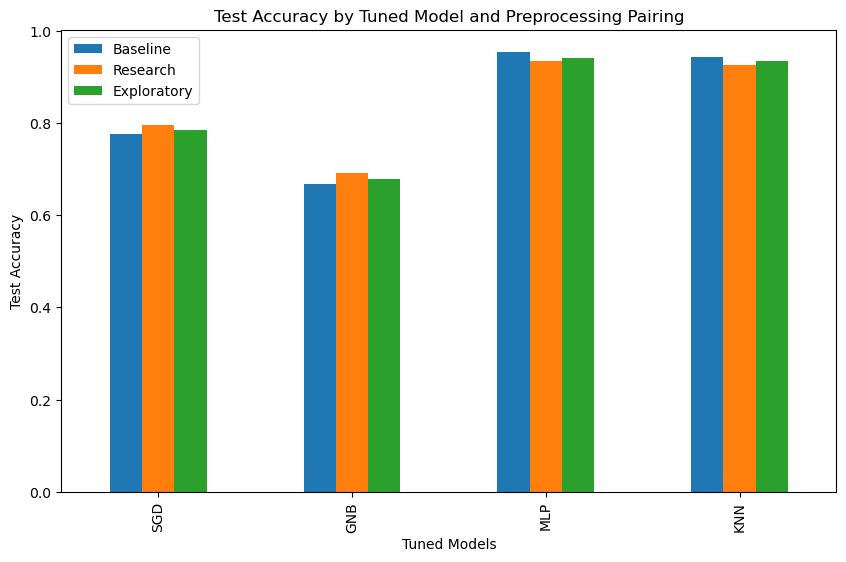

In [52]:
models = ['SGD', 'GNB', 'MLP', 'KNN']
pairings = ['Baseline', 'Research', 'Exploratory']

#All model data stored in these dictionaries. Use these to calculate scores.
train_actual = {'Baseline': y_train_baseline, 'Research': y_train_research, 'Exploratory': y_train_exploratory}
train_predictions = {
    'SGD': {'Baseline': new_sgd_train_pred_baseline, 'Research': new_sgd_train_pred_research, 'Exploratory': new_sgd_train_pred_exploratory},
    'GNB': {'Baseline': new_gnb_train_pred_baseline, 'Research': new_gnb_train_pred_research, 'Exploratory': new_gnb_train_pred_exploratory},
    'MLP': {'Baseline': new_mlp_train_pred_baseline, 'Research': new_mlp_train_pred_research, 'Exploratory': new_mlp_train_pred_exploratory},
    'KNN': {'Baseline': new_knn_train_pred_baseline, 'Research': new_knn_train_pred_research, 'Exploratory': new_knn_train_pred_exploratory},
}

test_actual = {'Baseline': y_test_baseline, 'Research': y_test_research, 'Exploratory': y_test_exploratory}
test_predictions = {
    'SGD': {'Baseline': new_sgd_y_pred_baseline, 'Research': new_sgd_y_pred_research, 'Exploratory': new_sgd_y_pred_exploratory},
    'GNB': {'Baseline': new_gnb_y_pred_baseline, 'Research': new_gnb_y_pred_research, 'Exploratory': new_gnb_y_pred_exploratory},
    'MLP': {'Baseline': new_mlp_y_pred_baseline, 'Research': new_mlp_y_pred_research, 'Exploratory': new_mlp_y_pred_exploratory},
    'KNN': {'Baseline': new_knn_y_pred_baseline, 'Research': new_knn_y_pred_research, 'Exploratory': new_knn_y_pred_exploratory},
}

#Store all metrics in a mutlileveled dictionary for easy access.
tuned_results = {model: {pair: {} for pair in pairings} for model in models}

for model in models:
    for pair in pairings:
        tuned_results[model][pair] = {
            'train_accuracy': accuracy_score(train_actual[pair], train_predictions[model][pair]),
            'test_accuracy': accuracy_score(test_actual[pair], test_predictions[model][pair]),
            'precision': precision_score(test_actual[pair], test_predictions[model][pair]),
            'recall': recall_score(test_actual[pair], test_predictions[model][pair]),
            'f1': f1_score(test_actual[pair], test_predictions[model][pair]),
            'roc_auc': roc_auc_score(test_actual[pair], test_predictions[model][pair])
        }
        
#Display a graph with the test accuracies for each model and pairing.

desired_metric = 'test_accuracy' #Change the metric type here.

test_accuracy_df = pd.DataFrame({model: {pair: tuned_results[model][pair][desired_metric] for pair in pairings} for model in models}).T
fig, ax = plt.subplots(figsize=(10, 6))
test_accuracy_df.plot(kind='bar', ax=ax)

ax.set_xlabel('Tuned Models')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy by Tuned Model and Preprocessing Pairing')

## 8. Evaluation Metrics

Now, all steps of the approach have been completed, and it is time to evaluate how to different models and pairing performed. This section will answer the questions related to the project objectives, such as if new models or pairings introduced performed better than models and pairings taken from other papers. In addition, this section will explore how feature engineering and parameter tuning impacted model performance and if the models overfitted or not.

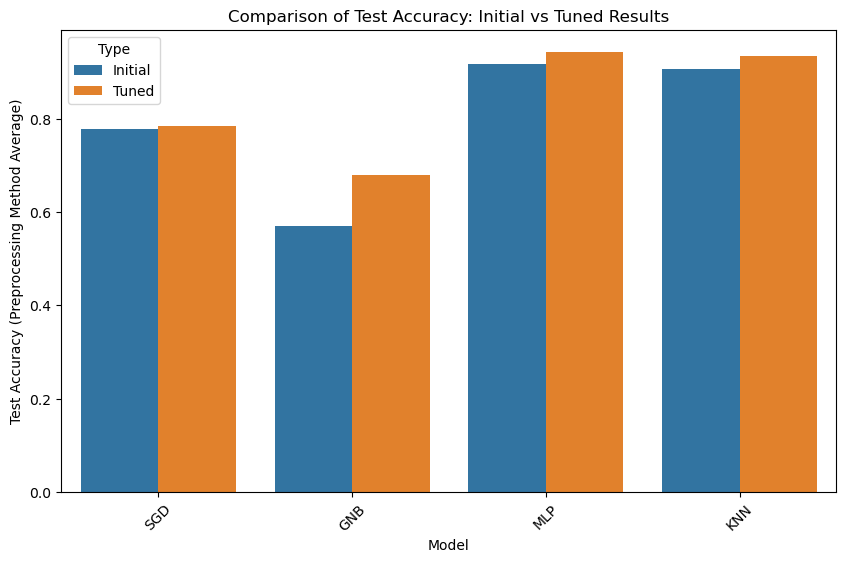

In [42]:
import seaborn as sns

#Compares the initial models with the models after hyperparameter tuning.
hyper_data = []
for model in models:
    for pair in pairings:
        hyper_data.append({
            'Model': model,
            'Pairing': pair,
            'Type': 'Initial',
            'Test Accuracy': initial_results[model][pair]['test_accuracy'] #Change value here for different metric views.
        })
        hyper_data.append({
            'Model': model,
            'Pairing': pair,
            'Type': 'Tuned',  
            'Test Accuracy': tuned_results[model][pair]['test_accuracy'] #Change value here for different metric views.
        })

plt.figure(figsize=(10, 6))
sns.barplot(x = 'Model', y = 'Test Accuracy', hue = 'Type', errorbar = None, data = pd.DataFrame(hyper_data))

plt.xlabel('Model')
plt.ylabel('Test Accuracy (Preprocessing Method Average)')
plt.title('Comparison of Test Accuracy: Initial vs Tuned Results')
plt.xticks(rotation=45)
plt.show()

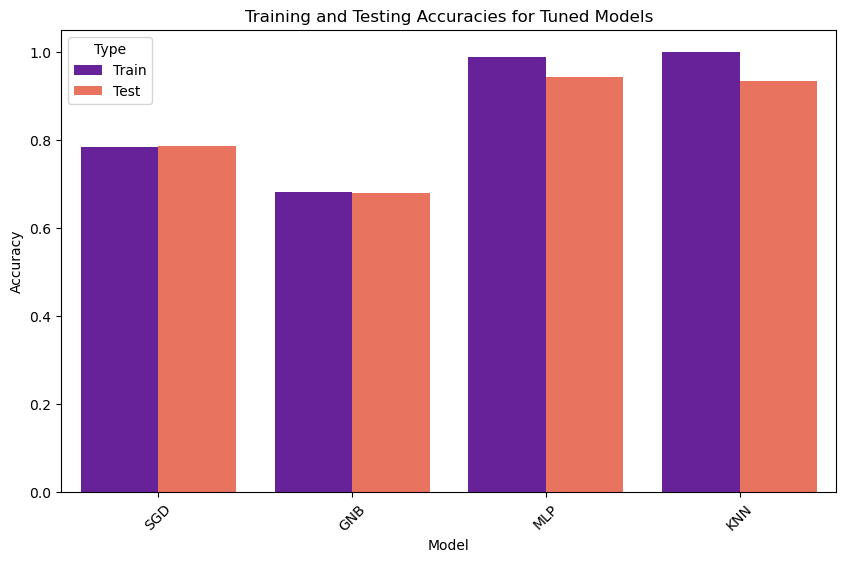

In [51]:
#Compares the tuned training and testing data to check for overfitting.
overfit_data = []
for model in models:
    for pair in pairings:
        overfit_data.append({
            'Model': model,
            'Pairing': pair,
            'Type': 'Train',
            'Accuracy': tuned_results[model][pair]['train_accuracy']
        })
        overfit_data.append({
            'Model': model,
            'Pairing': pair,
            'Type': 'Test',
            'Accuracy': tuned_results[model][pair]['test_accuracy']
        })

palette = {
    'Train': '#6a0dad',
    'Test': '#ff6347'
}
plt.figure(figsize=(10, 6))
sns.barplot(x = 'Model', y = 'Accuracy', hue = 'Type', errorbar = None, data = pd.DataFrame(overfit_data), palette = palette)

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies for Tuned Models')
plt.xticks(rotation=45)
plt.show()